In [7]:
import numpy as np
import matplotlib.pyplot as plt
from quantify_core.data.handling import (
    default_datadir,
    get_latest_tuid,
    load_dataset,
    locate_experiment_container,
    set_datadir,
    get_tuids_containing,
)

In [8]:
set_datadir(default_datadir())

Data will be saved in:
/home/pschaefers/quantify-data


In [9]:
tuid = get_latest_tuid(contains="Adaptive_Old_Reps")
dataset = load_dataset(tuid)
dataset

<xarray.Dataset> Size: 26kB
Dimensions:  (dim_0: 330)
Coordinates:
    x0       (dim_0) float64 3kB 7.805e+09 7.813e+09 ... 7.832e+09 7.834e+09
    x1       (dim_0) float64 3kB 0.03285 0.03373 0.03283 ... 0.04732 0.04959
    x2       (dim_0) float64 3kB 1.24e-07 1.16e-07 6.8e-08 ... 4.24e-07 4.36e-07
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 3kB 0.0 -1.518 -1.544 ... -5.028 -4.966 -4.985
    y1       (dim_0) float64 3kB 0.753 0.5619 0.5375 ... 0.8423 0.8473 0.8447
    y2       (dim_0) float64 3kB 0.527 0.5614 0.5422 ... 0.9809 0.9788 0.9771
    y3       (dim_0) float64 3kB 0.8636 0.5642 0.545 ... 0.9778 0.976 0.9762
    y4       (dim_0) float64 3kB 0.8683 0.5601 0.5253 ... 0.5681 0.5872 0.5807
    y5       (dim_0) float64 3kB nan 0.5029 0.5435 ... 0.9597 0.9565 0.9597
    y6       (dim_0) float64 3kB nan 0.5 0.5383 0.5 ... 0.9584 0.9543 0.9559
Attributes:
    tuid:                             20250428-153540-310-df4665
    name:                             CMAES_QNDPi_Readout_Adaptive_Reps ['D6']
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  True
    elements:                         D6
    edges:                            []

In [10]:
def process_fidelity_data(dataset, popsize, n_qubits):
    """
    Processes fidelity data for n qubits based on the given dataset and population size.

    Parameters:
        dataset: An object containing data attributes (e.g., dataset.x0.data, dataset.y0.data, etc.).
        popsize: The size of the population.
        n_qubits: The number of qubits.

    Returns:
        A dictionary containing mean and population fidelity data for all qubits and shared parameters.
    """
    # Extract parameters shared across all qubits
    shared_data = {
        'freq': dataset.x0.data,
        'ampl': dataset.x1.data,
        'dur': dataset.x2.data,
        'objective': dataset.y0.data,
    }

    # Initialize dictionary to hold data for each qubit
    fidelity_data = {'shared': shared_data}

    for q in range(1, n_qubits + 1):
        # Start index for each qubit's fidelity data (y1 onwards, 6 values per qubit)
        start_idx = 1 + (q - 1) * 6
        # Extract fidelity data for the current qubit
        fidelity_data[f'q{q}'] = {
            'assfid_av': getattr(dataset, f'y{start_idx}').data,
            'assfid_01': getattr(dataset, f'y{start_idx + 1}').data,
            'assfid_02': getattr(dataset, f'y{start_idx + 2}').data,
            'assfid_12': getattr(dataset, f'y{start_idx + 3}').data,
            'qndfid': getattr(dataset, f'y{start_idx + 4}').data,
            'qndpifid': getattr(dataset, f'y{start_idx + 5}').data,
        }

        # Calculate mean fidelity values
        fidelity_data[f'q{q}']['mean'] = {
            key: fidelity_data[f'q{q}'][key][popsize::popsize + 1]
            for key in ['assfid_av', 'assfid_01', 'assfid_02', 'assfid_12', 'qndfid', 'qndpifid']
        }

        # print(fidelity_data[f'q{q}']['assfid_av'][0::popsize+1])
        # Calculate population fidelity values using the new slicing logic
        fidelity_data[f'q{q}']['pop'] = {
            key: np.array([
                fidelity_data[f'q{q}'][key][i::popsize+1]
                for i in range(popsize)
            ])
            for key in ['assfid_av', 'assfid_01', 'assfid_02', 'assfid_12', 'qndfid', 'qndpifid']
        }


    return fidelity_data

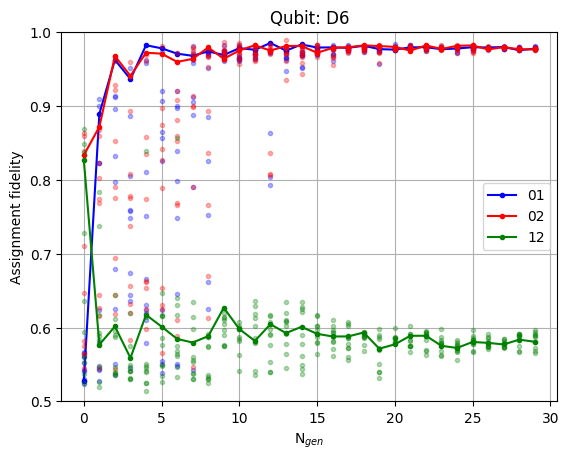

In [11]:
Ngen = 30
n_qubits = 1
popsize = 10

fidelity_results = process_fidelity_data(dataset, popsize, n_qubits)
# Access shared data
shared_params = fidelity_results['shared']

# Access results for a specific qubit
qubit1_mean = fidelity_results['q1']['mean']['assfid_01']  # Mean fidelity values for qubit 1
qubit1_pop = fidelity_results['q1']['pop']['assfid_01']

# Access results for a specific qubit
qubit2_mean = fidelity_results['q1']['mean']['assfid_02']  # Mean fidelity values for qubit 1
qubit2_pop = fidelity_results['q1']['pop']['assfid_02']

# Access results for a specific qubit
qubit3_mean = fidelity_results['q1']['mean']['assfid_12']  # Mean fidelity values for qubit 1
qubit3_pop = fidelity_results['q1']['pop']['assfid_12']

plt.plot(range(Ngen),qubit1_mean,'-o',c="blue",ms=3, label="01")
for i in range(popsize):
    plt.plot(range(Ngen),qubit1_pop[i],".",c="blue",alpha=.3)

plt.plot(range(Ngen),qubit2_mean,'-o',c="red",ms=3, label="02")
for i in range(popsize):
    plt.plot(range(Ngen),qubit2_pop[i],".",c="red",alpha=.3)

plt.plot(range(Ngen),qubit3_mean,'-o',c="green",ms=3, label="12")
for i in range(popsize):
    plt.plot(range(Ngen),qubit3_pop[i],".",c="green",alpha=.3)

plt.ylim(0.5,1)
plt.title("Qubit: D6")
plt.ylabel("Assignment fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()


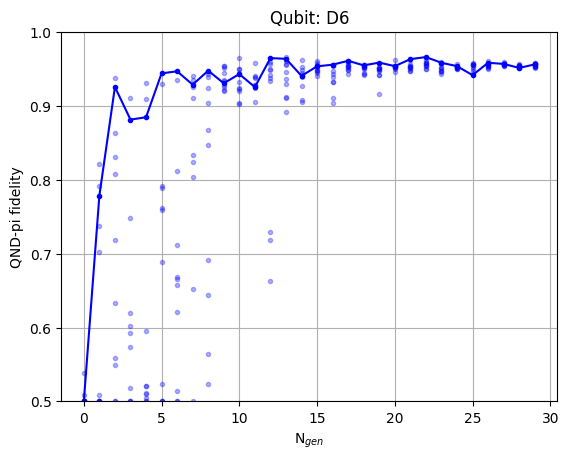

In [12]:
Ngen = 30
n_qubits = 1
popsize = 10

fidelity_results = process_fidelity_data(dataset, popsize, n_qubits)
# Access shared data
shared_params = fidelity_results['shared']

# Access results for a specific qubit
qubit1_mean = fidelity_results['q1']['mean']['qndpifid']  # Mean fidelity values for qubit 1
qubit1_pop = fidelity_results['q1']['pop']['qndpifid']


plt.plot(range(Ngen),qubit1_mean,'-o',c="blue",ms=3)
for i in range(popsize):
    plt.plot(range(Ngen),qubit1_pop[i],".",c="blue",alpha=.3)

plt.ylim(0.5,1)
plt.title("Qubit: D6")
plt.ylabel("QND-pi fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
# plt.legend()
plt.show()


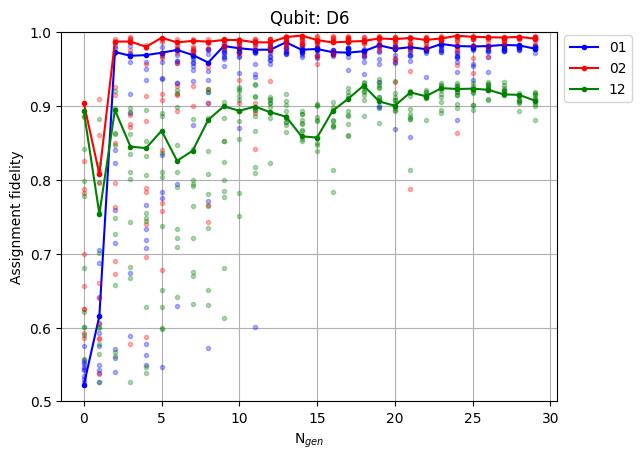

In [24]:
tuids = get_tuids_containing('Adaptive_Reps')

tuids = [tuids[5]]

for tuid in tuids:
    dataset = load_dataset(tuid)

    # if tuid == tuids[0]:
    #      print(dataset)
    
    qubit = dataset.elements

    Ngen = 30
    n_qubits = 1
    popsize = 10
    
    fidelity_results = process_fidelity_data(dataset, popsize, n_qubits)
    # Access shared data
    shared_params = fidelity_results['shared']
    
    # Access results for a specific qubit
    qubit1_mean = fidelity_results['q1']['mean']['assfid_01']  # Mean fidelity values for qubit 1
    qubit1_pop = fidelity_results['q1']['pop']['assfid_01']
    
    # Access results for a specific qubit
    qubit2_mean = fidelity_results['q1']['mean']['assfid_02']  # Mean fidelity values for qubit 1
    qubit2_pop = fidelity_results['q1']['pop']['assfid_02']
    
    # Access results for a specific qubit
    qubit3_mean = fidelity_results['q1']['mean']['assfid_12']  # Mean fidelity values for qubit 1
    qubit3_pop = fidelity_results['q1']['pop']['assfid_12']
    
    plt.plot(range(Ngen),qubit1_mean,'-o',c="blue",ms=3, label="01")
    for i in range(popsize):
        plt.plot(range(Ngen),qubit1_pop[i],".",c="blue",alpha=.3)
    
    plt.plot(range(Ngen),qubit2_mean,'-o',c="red",ms=3, label="02")
    for i in range(popsize):
        plt.plot(range(Ngen),qubit2_pop[i],".",c="red",alpha=.3)
    
    plt.plot(range(Ngen),qubit3_mean,'-o',c="green",ms=3, label="12")
    for i in range(popsize):
        plt.plot(range(Ngen),qubit3_pop[i],".",c="green",alpha=.3)
    
    plt.ylim(0.5,1)
    plt.title(f"Qubit: {qubit}")
    plt.ylabel("Assignment fidelity")
    plt.xlabel(r"N$_{gen}$")
    plt.grid()
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.01))
    plt.show()

In [4]:
tuid = get_latest_tuid(contains="QND D6")
dataset2 = load_dataset(tuid)
dataset2

<xarray.Dataset> Size: 11MB
Dimensions:  (dim_0: 450000)
Coordinates:
    x0       (dim_0) int32 2MB 0 1 2 3 4 5 ... 89995 89996 89997 89998 89999
    x1       (dim_0) int32 2MB 0 0 0 0 0 0 0 0 0 0 0 0 ... 4 4 4 4 4 4 4 4 4 4 4
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 4MB 0.0001622 -4.104e-05 ... 0.0005149 0.003056
    y1       (dim_0) float64 4MB 0.004693 0.004451 ... 0.0001632 0.003259
Attributes:
    tuid:                             20250429-110724-940-187614
    name:                             SSRO QND D6 Chained x10
    grid_2d:                          True
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  True
    xlen:                             90000
    ylen:                             5
    elements:                         D6
    edges:                            []

FigureContainer(figure_object=<Figure size 1500x500 with 6 Axes>)

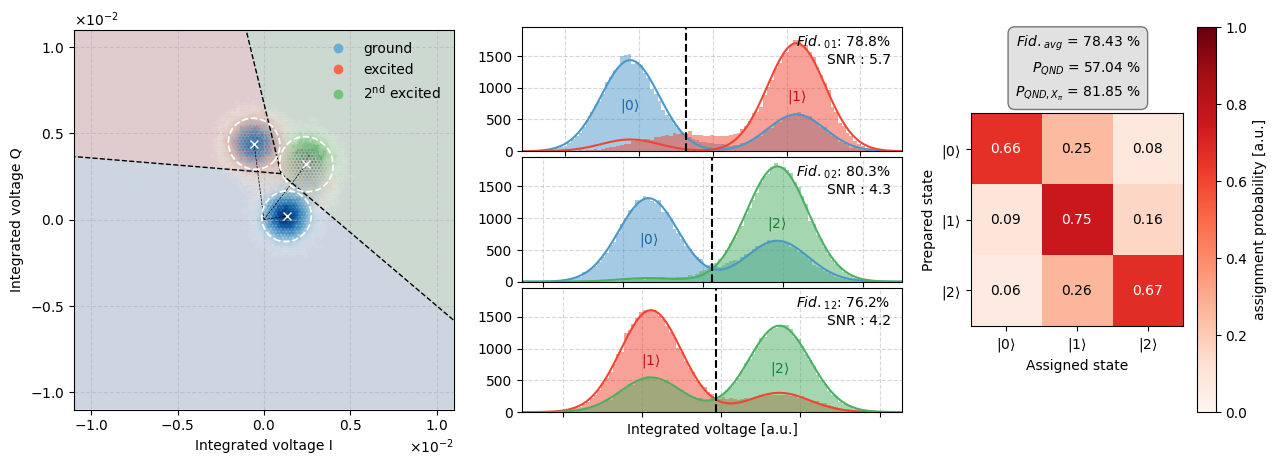

In [5]:
from qce_utils.support_classes.xarray_bootstrap import XarrayBootstrap
from qce_utils.addon_quantify.object_factories.factory_state_acquisition import (
    QNDPiOptimizationFactory,
    QNDPiStateClassifierFactory,
    AcquisitionType,
)
from qce_utils.control_interfaces.datastorage_control.analysis_factories.factory_state_classification import (
    QNDPiStateClassifierAnalysis,
)
from qce_utils.qed_modeling.intrf_state_classification import (
    IQNDPiStateClassifierContainer,
    RepeatedQNDPiStateClassifierContainer,
)

dataset = XarrayBootstrap(data=dataset2)
data_object: RepeatedQNDPiStateClassifierContainer = QNDPiStateClassifierFactory(
    acquisition_type=AcquisitionType.THREE_STATE,
    use_heralded_post_selection=True,
    qnd_repetitions=1,
).construct(dataset)

analysis_factory = QNDPiStateClassifierAnalysis()
analysis_factory.construct_figure(data_object)
    